# 3.3 Bayes 线性回归

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline

之前的讨论中，我们使用统计上的极大似然估计的方法来找到模型的参数，我们看到，为了得到较好的结果，我们需要控制模型的复杂度，即选择一个合适的基函数个数；或者通过加上正则项来解决。

通常模型的复杂性不能通过极大似然函数来单独决定，因为极大似然估计通常都伴随着过拟合的现象，我们可以考虑使用独立的验证集来控制模型复杂度，但这通常是非常昂贵的。

我们考虑用 Bayes 的角度来看待线性回归的问题。

## 3.3.1 参数分布 

考虑单目标变量 $t$ 的情况，我们先考虑给我们的参数 $\bf w$ 加上一个先验分布，这里我们先认为噪音的参数 $\beta$ 是已知的。在 $N$ 个数据点的情况下，之前我们得到 $p(\mathsf t|\mathbf w)$ 的分布：

$$
p(\mathsf t|\mathbf{X,w},\beta) = \prod_{n=1}^N \mathcal N(t_n|\mathbf w^\top\mathbf \phi(\mathbf x_n),\beta^{-1})
$$

是一个 $\bf w$ 二次型的指数形式，因此，我们考虑使用高斯分布的先验：

$$
p(\mathbf w)=\mathcal N(\mathbf w|\mathbf m_0,\mathbf S_0)
$$

利用${\rm posterior} \propto {\rm prior} \times {\rm likelihood}$ 以及共轭性，我们知道后验分布也是一个高斯分布：

$$
p(\mathbf w|\mathsf t)=\mathcal N(\mathbf w|\mathbf m_N,\mathbf S_N)
$$

不难计算得到：

$$
\begin{aligned}
\mathbf m_N & = \mathbf S_N(\mathbf S_0^{-1}\mathbf m_0+\beta\mathbf\Phi^\top\mathsf t) \\
\mathbf S_N^{-1} & = \mathbf S_0^{-1} + \beta\mathbf{\Phi^\top\Phi}
\end{aligned}
$$

其中

$$
\mathbf\Phi = \begin{pmatrix}
\mathbf\phi(\mathbf x_1)^\top \\
\mathbf\phi(\mathbf x_2)^\top \\
\vdots \\
\mathbf\phi(\mathbf x_N)^\top \\
\end{pmatrix}  = \begin{pmatrix}
\phi_0(\mathbf x_1) & \phi_1(\mathbf x_1) & \cdots & \phi_{M-1}(\mathbf x_1) \\
\phi_0(\mathbf x_2) & \phi_1(\mathbf x_2) & \cdots & \phi_{M-1}(\mathbf x_2) \\
\vdots & \vdots  & \ddots & \vdots\\
\phi_0(\mathbf x_N) & \phi_1(\mathbf x_N) & \cdots & \phi_{M-1}(\mathbf x_n)\\
\end{pmatrix}
$$

在高斯分布的情况下，均值就是众数，因此，最大后验给出：

$$
\mathbf w_{MAP} = \mathbf m_N
$$

如果我们考虑一个无限宽的先验：$\mathbf S_0 = \alpha\mathbf I, \alpha\to 0$，那么我们的最大后验结果就是极大似然的结果；类似的，如果 $N=0$，那么后验分布就是先验分布，与之前的讨论类似，我们可以将这个模型改成在线的。

如果我们考虑一个零均值的各向同性的先验：

$$
p(\mathbf w|\alpha) = \mathcal N(\mathbf 0,\alpha\mathbf I)
$$

我们有：

$$
\begin{aligned}
\mathbf m_N & = \beta\mathbf S_N\mathbf\Phi^\top\mathsf t \\
\mathbf S_N^{-1} & = \alpha\mathbf I + \beta\mathbf{\Phi^\top\Phi}
\end{aligned}
$$

此时，后验分布的对数为：

$$
\ln p(w|t) = \underbrace{-\frac{\beta}{2}\sum_{n=1}^N \{t_n-\mathbf{w^\top\phi(x}_n)\}^2}_{\rm likelihood} - \underbrace{\frac{\alpha}{2} \mathbf{w^\top w}}_{\rm prior} + {\rm const}
$$

因此，在这种情况下，最大后验分布，相当于加了一个二范数正则的最小二乘，正则系数 $\lambda = \alpha/\beta$。

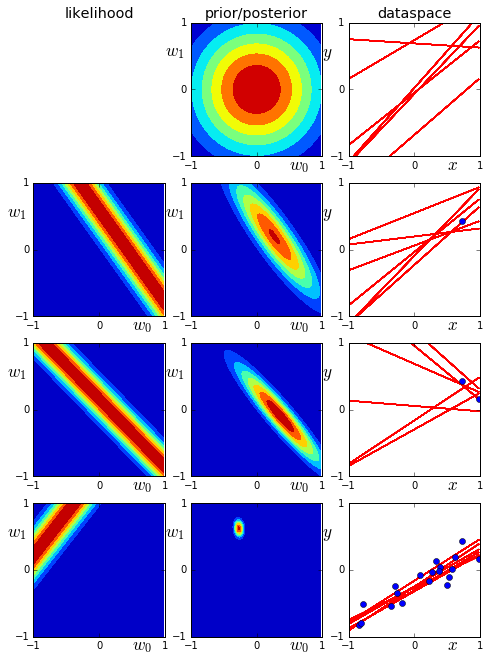

In [2]:
from scipy.stats import uniform, norm
from matplotlib.mlab import bivariate_normal
from scipy.stats import multivariate_normal
from numpy import linalg

a0, a1 = -0.3, 0.5
bt = 25.0
s = np.sqrt(1.0 / bt)
ap = 2.0

xx = uniform.rvs(loc=-1, scale=2, size=(20,))
tt = a0 + a1 * xx + norm.rvs(loc=0, scale=s, size=(20,))

_, axes = plt.subplots(4, 3, figsize=(8, 11))

x, y = np.mgrid[-1:1:.02, -1:1:.02]

nums = [0, 1, 2, 20]

phi = np.vstack((np.ones(20), xx)).T

for idx in range(4):
    n = nums[idx]
    if idx == 0:
        axes[idx][0].axis("off")
        axes[idx][0].set_title("likelihood", fontsize="x-large")
        axes[idx][1].set_title("prior/posterior", fontsize="x-large")
        axes[idx][2].set_title("dataspace", fontsize="x-large")
    else:
        z1 = 1 / np.sqrt(2*np.pi) / s *np.exp(-(tt[n-1] - x - y * xx[n-1]) ** 2 / 2 / s ** 2) 
        axes[idx][0].contourf(x, y, z1)
        axes[idx][0].set_xticks([-1, 0, 1])
        axes[idx][0].set_ylim(-1, 1)
        axes[idx][0].set_yticks([-1, 0, 1])
        axes[idx][0].text(0.5, -1.2, '$w_0$', fontsize='xx-large')
        axes[idx][0].text(-1.4, 0.5, '$w_1$', fontsize='xx-large')
        
    S = linalg.inv(ap * np.eye(2) + bt * np.dot(phi[:n].T, phi[:n]))
    mu = bt * np.dot(np.dot(S, phi[:n].T), tt[:n])
    
    z = bivariate_normal(x, y, 
                         mux=mu[0], muy=mu[1],
                         sigmax=np.sqrt(S[0][0]), 
                         sigmay=np.sqrt(S[1][1]), 
                         sigmaxy=S[0][1])
    ww = multivariate_normal.rvs(mean=mu,
                                 cov=S, 
                                 size=6)
    ww0, ww1 = ww[:, 0], ww[:, 1]
    for idy in range(6):
        axes[idx][2].plot(x, ww0[idy] + ww1[idy] * x, 'r')
    
    axes[idx][1].contourf(x, y, z)
    axes[idx][1].set_xticks([-1, 0, 1])
    axes[idx][1].set_ylim(-1, 1)
    axes[idx][1].set_yticks([-1, 0, 1])
    axes[idx][1].text(0.5, -1.2, '$w_0$', fontsize='xx-large')
    axes[idx][1].text(-1.4, 0.5, '$w_1$', fontsize='xx-large')

    axes[idx][2].plot(xx[:n], tt[:n], 'o')
    axes[idx][2].set_xticks([-1, 0, 1])
    axes[idx][2].set_ylim(-1, 1)
    axes[idx][2].set_yticks([-1, 0, 1])
    axes[idx][2].text(0.5, -1.2, '$x$', fontsize='xx-large')
    axes[idx][2].text(-1.4, 0.5, '$y$', fontsize='xx-large')

plt.show()

我们考虑一个单变量 $x$，单目标 $t$ 的情况，并使用一个线性模型：$y(x,\mathbf w)=w_0+w_1x$。我们使用函数 $f(x,\mathbf a)=a_0+a_1x$ 生成一组 $x\in U[-1,1]$ 之间的数据，并加上零均值 $\beta=25$ 的高斯噪声，这里 $a_0 = -0.3, a_1 = 0.5$，令 $\alpha=2$，考虑数据点不断增加时，后验分布的变化情况，如上图所示。

- 第一行
  - 第 2 列：先验分布
  - 第 3 列：从先验分布中随机选取 6 组 $\bf w$ 值得到的曲线
- 第二行：
  - 第 1 列：第 1 个数据点的似然函数 $p(t_1|x_1, \bf w)$
  - 第 2 列：加入第 1 个数据点的后验分布
  - 第 3 列：从后验分布中随机选取 6 组 $\bf w$ 值得到的曲线
- 第三行：
  - 第 2 列：第 2 个数据点的似然函数 $p(t_2|x_2, \bf w)$
  - 第 2 列：加入第 2 个数据点的后验分布
  - 第 3 列：从后验分布中随机选取 6 组 $\bf w$ 值得到的曲线
- 第四行：
  - 第 2 列：第 20 个数据点的似然函数 $p(t_{20}|x_{20}, \bf w)$
  - 第 2 列：加入第 20 个数据点的后验分布
  - 第 3 列：从后验分布中随机选取 6 组 $\bf w$ 值得到的曲线
  
当然我们可以一般化高斯分布先验为（高斯分布对应于 $q=2$）：

$$
p(\mathbf w|\alpha)=\left[\frac{q}{2}\left(\frac{\alpha}{2}\right)^{1/q} \frac{1}{\Gamma(1/q)}\right]^M \exp\left(-\frac{\alpha}{2}\sum_{j=1}^M |w_j|^q\right)
$$

此时 MAP 对应于更一般的正则项形式：

$$
\frac{1}{2}\sum_{n=1}^N \{t_n-\mathbf w^\top\mathbf \phi(\mathbf x_n)\}^2 + \frac \lambda 2 \sum_{j=1}^M |w_j|^q
$$

在这种情况下，其 MAP 的值不一定为均值。

## 3.3.2 预测值分布